# 1. Agent: 검색엔진 활용

### 라이브러리 호출

In [1]:
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama
from langchain.agents import AgentExecutor, create_react_agent

load_dotenv()

True

### 프롬프트 생성

* 프롬프트에는 Agent에 포함할 Tool과 Tool의 이름, agent_scratched가 포함되어 있어야 함.
* 프롬프트는 생각(Thouht), 행동(Action), 관찰(Observation)에 어떻게 동작해야 하는지를 작성해야 함.
* chat_history 를 입력으로 받아서 이전의 응답과 일관적으로 동작함.


In [2]:
# 1. 프롬프트 템플릿 준비
#    {tools} : 사용가능한 도구를 Agent 에게 알려주기 위해 필요한 파라미터 (필수)
#    {tool_names} : 다음 작업(Action)에 필요한 도구들을 표시하는 파라미터 (필수)
#    {agent_scratchpad} : Agent 가 수행해야 하는 작업의 내용을 표시 (필수)
prompt = ChatPromptTemplate.from_template(
    """당신은 유능한 기상학자입니다. 필요한 경우 다음 도구들을 사용할 수 있습니다: 
    {tools}

    Use the following format:
        Thought: you should always think about what to do
        Action: the action to take, should be one of [{tool_names}]
        Action Input: the input to the action
        Observation: the result of the action
        ... (this Thought/Action/Action Input/Observation can repeat N times)
        Thought: I now know the final answer
        Final Answer: the final answer to the original input question
    ============================= Chat history =============================
    {chat_history}
    ================================ Human Message =================================
    Question: {question}
    ============================= Messages Placeholder =============================
    Thought: {agent_scratchpad}
    """
)

### Agent 생성

* LLM 모델은 Exaone 3.5의 7.8b 버전을 사용함.
* Tool은 DuckDuckGoSearchRun() 모듈을 사용함.
* LLM, Tool, Prompt를 입력으로 Agent를 생성함. create_react_agent는 ReAct 방식으로 동작하는 Agent를 생성함.
* Agent는 AgentExecutor를 사용해서 실행됨.

In [ ]:
# 2. LLM 초기화
llm = ChatOllama(model="exaone3.5:7.8b", temperature=0.8)

# 3. DuckDuckGo 검색 도구 초기화
search = DuckDuckGoSearchRun()
tools = [search]

# # ✅ Tavily 검색 도구 초기화 (API 키 필수) https://www.tavily.com/
# import os
# from langchain_community.tools.tavily_search import TavilySearchResults
# os.environ["TAVILY_API_KEY"] = "" # Tavily API key
# search = TavilySearchResults(api_key="YOUR_TAVILY_API_KEY")
# tools = [search]

# 4. agent 생성
agent = create_react_agent(llm, tools, prompt)
# 4-1. agent_executor 생성
agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True, verbose=True)

### 챗봇

* 검색 도구를 LLM이 잘 활용하는지 테스트하기 위해 챗봇 코드로 LLM이 알지 못하는 최신 정보를 물어보기 위한 코드

In [ ]:
# 이전 챗을 기억하기 위해 chat_history 사용
chat_history = []

# 5. 챗 실행
while True:
    # 5-1. 사용자 질문을 입력 받음
    user_input = input("\n\n당신 (종료 q): ") # example) Q: 2024년 태풍 발생 상황에 대해 알려줘
    if user_input in ("끝", "종료", "q", "exit"):
        break
    print("User ---> \n", user_input, "\n")
    # 5-2. Agent 실행
    result = agent_executor.invoke(
        {"question": user_input, "chat_history": chat_history}
    )
    # 5-3. 응답이 dictionary 로 전달되므로 output 만 추출해서 출력
    output_text = result["output"]
    print(f"\nAI --->\n{output_text}")

    # 대화내역 저장
    chat_history.append(f"user: {user_input}")
    chat_history.append(f"assistant: {output_text}")

User ---> 
 2024년 태풍 발생 상황에 대해 알려줘 



> Entering new AgentExecutor chain...
Thought: 2024년의 태풍 발생 상황에 대한 정확한 정보를 제공하기 위해서는 실시간 데이터와 최신 기상 예보 정보가 필요합니다. 하지만 현재 시점에서 특정 연도의 과거 데이터를 제공하기보다는, 일반적인 태풍 발생 패턴과 예측 방법에 대해 설명하거나, 가장 최신의 정보를 찾아보는 것이 적절할 것 같습니다. 가장 최신의 태풍 동향을 확인하기 위해 DuckDuckGo 검색을 이용해보겠습니다.

Action: duckduckgo_search
Action Input: 최신 태풍 발생 동향 및 예측 (2024년 현재 상황 포함)오늘은 2024년 가을 태풍 상황에 대해 살펴보겠습니다. 최근 제16호 태풍 '시마론 (CIMARON)'이 일본 가고시마 남동쪽 해상에서 발생하며, 기상 상황에 대한 관심이 높아지고 있습니다. 다행히 이번 태풍은 빠르게 소멸할 것으로 예상되어 우리나라에 큰 영향을 미칠 가능성은 낮습니다. 기상청에 따르면, 태풍 시마론은 현재 중심기압 1002헥토파스칼 (hPa), 최대풍속 시속 65km로 강한 바람을 동반하고 있지만, 점차 에너지를 잃고 있습니다. 오늘 오전 3시에는 일본 가고시마 남동쪽 약 460km 부근 해상에 위치하며, 오후 3시에는 약 400km 부근 해상까지 이동할 것으로 보입니다. 2024년 태풍 예상 정보는 다음과 같습니다. 1. 예상 태풍 발생 횟수. · 2024년에는 전 세계적으로 약 80~90개의 태풍이 발생할 것으로 예상됩니다. · 이는 최근 30년 평균(약 84개)과 유사한 수준입니다. 2. 한반도 영향 태풍 수. · 한반도에 직접적인 영향을 미칠 것으로 예상되는 태풍은 약 5~7개 정도가 될 것으로 전망됩니다. · 이 중 상륙하는 태풍은 3~5개 정도가 될 것으로 예상됩니다. 3. 주요 영향 시기. · 한반도에 영향을 줄 것으로 예상되는 주요 태풍 시기는 7월부터 10월 사이가 될 

# 2. Agent: 두 개의 도구 활용

### 라이브러리 호출 및 프롬프트 생성 (앞과 동일)

In [5]:
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama
from langchain.agents import AgentExecutor, create_react_agent

load_dotenv()

True

In [6]:
# 프롬프트 템플릿 준비
#    {tools} : 사용가능한 도구를 Agent 에게 알려주기 위해 필요한 파라미터 (필수)
#    {tool_names} : 다음 작업(Action)에 필요한 도구들을 표시하는 파라미터 (필수)
#    {agent_scratchpad} : Agent 가 수행해야 하는 작업의 내용을 표시 (필수)

prompt = ChatPromptTemplate.from_template(
    """당신은 유능한 기상학자입니다. 필요한 경우 다음 도구들을 사용할 수 있습니다: 
    {tools}

    Use the following format:
        Thought: you should always think about what to do
        Action: the action to take, should be one of [{tool_names}]
        Action Input: the input to the action
        Observation: the result of the action
        ... (this Thought/Action/Action Input/Observation can repeat N times)
        Thought: I now know the final answer
        Final Answer: the final answer to the original input question
    ============================= Chat history =============================
    {chat_history}
    ================================ Human Message =================================
    Question: {question}
    ============================= Messages Placeholder =============================
    Thought: {agent_scratchpad}
    """
)

### 검색 도구와 연산(math) 도구 초기화

* 검색 결과에서 통계적인 처리를 하기 위한 Math 계산 도구의 초기화는 자연어의 수식 변환을 위해 LLM을 입력으로 사용함.
* tools 에 검색 도구와, 연산 도구가 함께 들어간 것 외에는 앞선 예제와 동일함.

In [ ]:
from langchain.chains.llm_math.base import LLMMathChain
from langchain.agents import Tool


llm = ChatOllama(model="exaone3.5:7.8b", temperature=0.8)

# 3-1. DuckDuckGo 검색 도구 초기화
search_tool = Tool(
    name="Search", func=DuckDuckGoSearchRun().run, description="DuckDuckGo 웹 검색 도구"
)

## ✅ Tavily 검색 도구 초기화 (API 키 필수) https://www.tavily.com/
# import os
# from langchain_community.tools.tavily_search import TavilySearchResults
# os.environ["TAVILY_API_KEY"] = "" # Tavily API key
# search_tool = Tool.from_function(
#     name="Search",
#     func=TavilySearchResults(api_key="YOUR_TAVILY_API_KEY").run,
#     description="TAVILY 웹 검색 도구"
# )

# Math 계산 도구 초기화
math_tool = Tool.from_function(
    name="Calculator",
    func=LLMMathChain.from_llm(llm=llm).run,
    description="""Useful for when you need to answer questions about math.
        This tool is only for math questions and nothing else.
        Only input math expressions.""",
)
# 도구 리스트 생성
tools = [search_tool, math_tool]

# agent 생성
agent = create_react_agent(llm, tools, prompt)
# agent_executor 생성
agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True, verbose=True)

### 챗봇

* 질문에 대한 통계정보 결과를 확인함

In [ ]:
# 이전 챗을 기억하기 위해 chat_history 사용
chat_history = []

# 챗 실행
while True:
    # 사용자 질문을 입력 받음
    user_input = input("\n\n당신 (종료 q): ") # example) Q: 서울의 인구는 얼마인가? 그리고 경기도 인구 대비 몇 퍼센트에 해당하는가?
    if user_input in ("끝", "q", "exit"):
        break

    # Agent 실행
    result = agent_executor.invoke(
        {"question": user_input, "chat_history": chat_history}
    )
    # 응답이 dictionary 로 전달되므로 output 만 추출해서 출력
    output_text = result["output"]
    print(f"\nAI --->\n{output_text}")

    # 대화내역 저장
    chat_history.append(f"user: {user_input}")
    chat_history.append(f"assistant: {output_text}")



> Entering new AgentExecutor chain...
Thought: 서울과 경기도의 최신 인구 통계 데이터를 찾아야 합니다. 각 지역의 인구 수를 비교하여 퍼센트를 계산할 수 있습니다.

Action: Search
Action Input: 최신 서울 인구 수와 경기도 인구 수, 그리고 가능하다면 최근 데이터를 제공하는 공식 통계 웹사이트나 보고서 이름
서울특별시 인구 추이 (나무위키): 해당 자료에 따르면 2025년 4월 기준 서울 인구는 9,331,860명으로 나타납니다. 이는 행정안전부 주민등록 인구통계와 동일한 수치입니다. 통계청의 장래인구추계 (2022년 발표): 2050년 서울 인구를 약 809만 명으로 예측하며 지속적인 감소 추세를 전망했습니다. 과거 예측 (2009년 연합뉴스): 2025년 서울 인구를 약 969만 명으로 예측했으나, 이는 15년 전 예측으로 현재의 인구 감소 추세를 반영하지 못할 가능성이 큽니다. e-나라지표 (2024년): 2024년 서울 인구를 약 939만 명으로 제시했습니다. 최근 20년 간 서울시 인구가 70만 명 감소한 반면 경기도 인구는 330만 명이나 늘어난 것으로 나타났다. 이에 따라 이 기간 중 양 단체 간 인구 격차는 55만 명에서 331만 명으로 6.02배 증가했다. 7일 경기도에 따르면 2005년부터 2024년까지 10년 ... 서울 인구 수는 도시 발전과 주거 트렌드를 반영하는 핵심 지표입니다. 지난 30년간 서울의 각 구별 인구수는 큰 변화를 겪었으며, 이에 따라 부동산 가격, 생활 인프라, 교통 등 다양한 요소가 영향을 받았습니다. 본 글에서는 2024년 기준 서울 각 구별 인구수를 정확히 1명 단위까지 분석하고, 최근 30년간의 변화를 전문적이고 쉽게 이해할 수 있도록 정리했습니다. 2024 서울 인구 수, 각 구별 상세 순위 분석 2024년 서울 인구 수는 총 9,431,256명입니다. 가장 인구가 많은 구는 송파구로 672,345명이며, 그 뒤를 강서구 (635,872명), 강남

# 실습문제: 사용자 정의 함수로 Tool 만들기

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import Tool
from langchain_ollama import ChatOllama
from langchain.agents import AgentExecutor, create_react_agent

In [27]:
prompt = ChatPromptTemplate.from_template(
    """Answer the following questions as best you can. You have access to the following tools:

    {tools}

    Use the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer\nFinal Answer: the final answer to the original input question

    Begin!

    Question: {input}
    Thought:{agent_scratchpad}""")

In [28]:
llm = ChatOllama(model="exaone3.5:7.8b", temperature=0.8)

In [ ]:
# 함수 정의
def get_text_length(text: str) -> int:
    """주어진 문자열의 길이를 반환하는 함수"""
    text = text.strip("\n")
    return len(text)

# Tool 객체로 래핑
custom_tool = Tool(
                    name="GetTextLength",
                    func=get_text_length,
                    description="Returns the number of characters in the given text."
                 )

#tools = []

# agent 생성
#agent = 
# agent_executor 생성
#agent_executor = 

In [ ]:
agent_executor.invoke({"input": "'KAMP'의 길이는?"})

# 부록: Tavily API 발급

### 1. https://www.tavily.com/ 접속 - 우측 상단 Log In 클릭 후 Google ID로 로그인

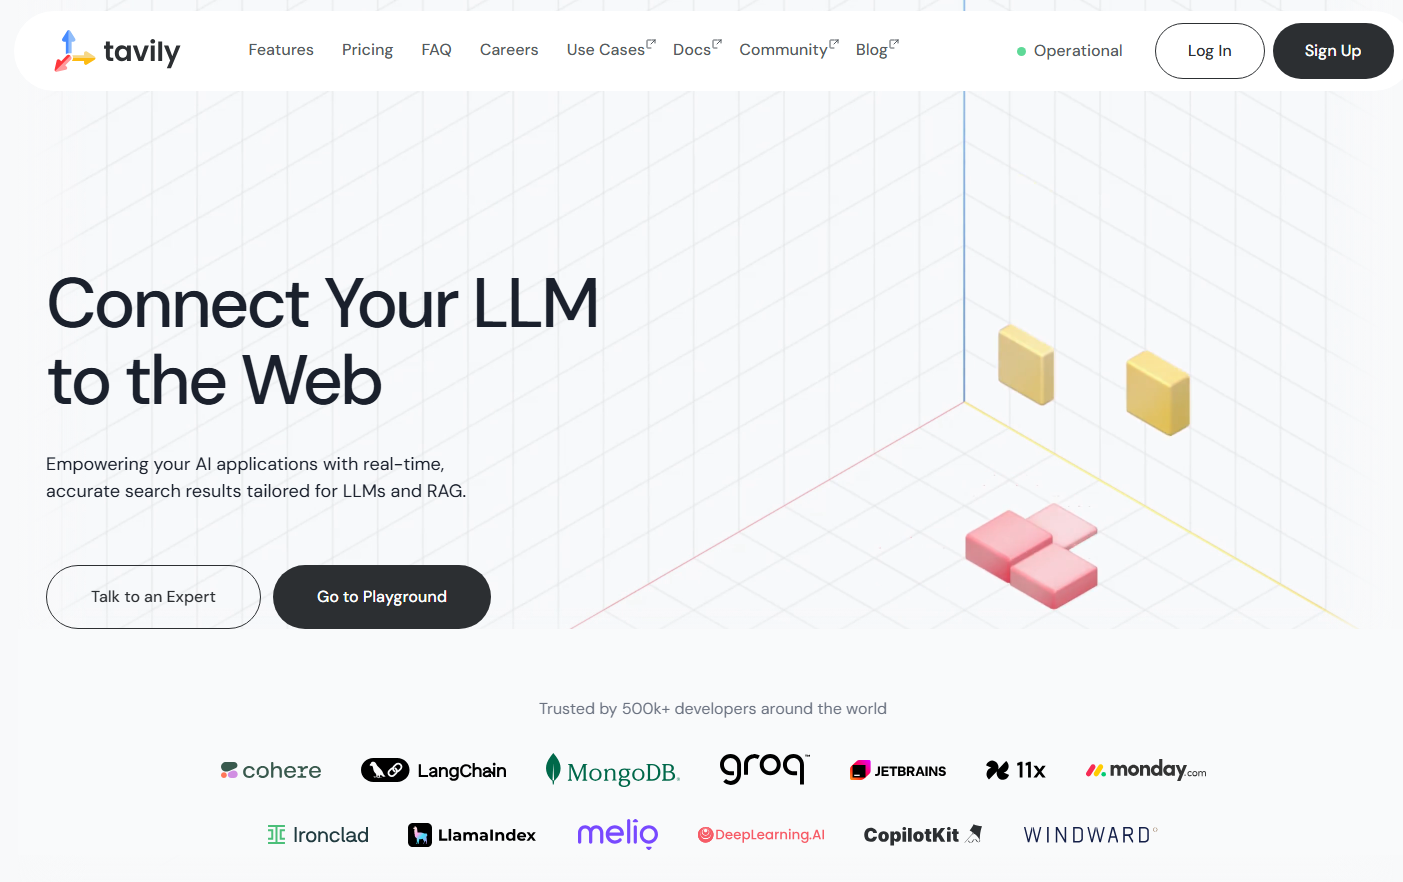

### 2. API Key "tvly-dev************" 복사

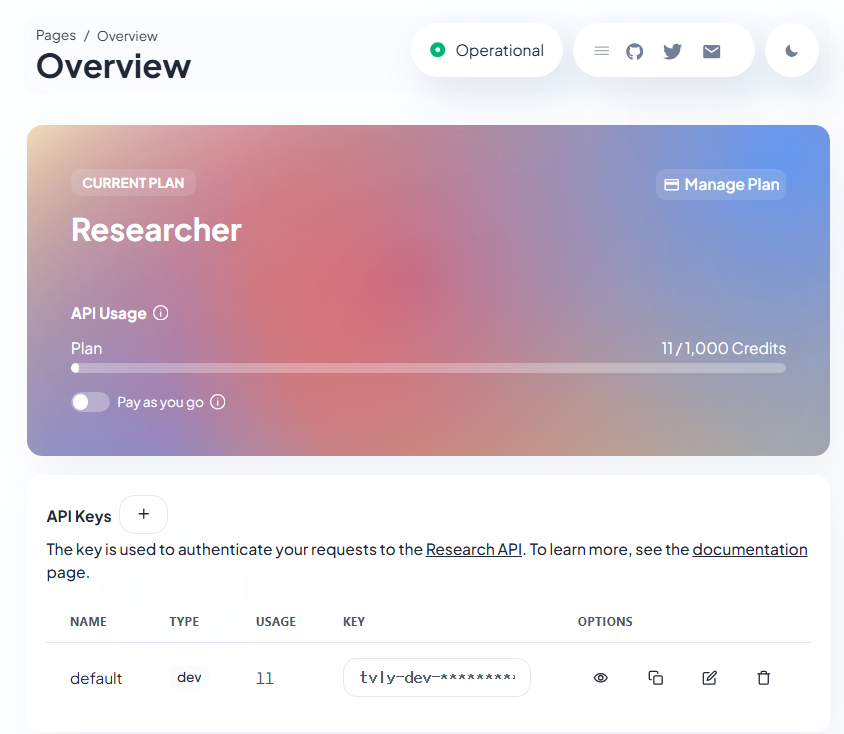